In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from torch.utils import data
import torch
import os
from from_scratch.dataset import Dataset, resize
from from_scratch.losses import ComputeLoss
from from_scratch.model import Yolo

In [19]:
dataset = Dataset('/home/davide/Desktop/change_detection/dataset', input_size=640)
train_loader = data.DataLoader(dataset, batch_size=32, num_workers=0, pin_memory=True, collate_fn=Dataset.collate_fn)
print(f"Train_loader: {len(train_loader)} batches")
batch = next(iter(train_loader))
print("All keys in batch: ", batch[1].keys())
print(f"Input batch shape: ", batch[0].shape)
print(f"Classification scores: {batch[1]['cls'].shape}")
print(f"Box coordinates: {batch[1]['box'].shape}")
print(f"Index identifier (which score belongs to which image): {batch[1]['idx'].shape}")


Train_loader: 4 batches
All keys in batch:  dict_keys(['cls', 'box', 'idx'])
Input batch shape:  torch.Size([32, 1, 640, 640])
Classification scores: torch.Size([135, 1])
Box coordinates: torch.Size([135, 4])
Index identifier (which score belongs to which image): torch.Size([135])


In [25]:
dataset.__getitem__(0)[2].shape

torch.Size([2, 4])

In [8]:
dataset = Dataset('/home/davide/Desktop/change_detection/dataset', input_size=640)
train_loader = data.DataLoader(dataset, batch_size=32, num_workers=0, pin_memory=True, collate_fn=Dataset.collate_fn)
print(f"Train_loader : {len(train_loader)} batches")

torch.manual_seed(42)

model = Yolo(version='n')
print(f"{sum(p.numel() for p in model.parameters())/1e6} million parameters")

criterion = ComputeLoss(model)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)

num_epochs = 40

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for imgs, targets in train_loader:
        imgs = imgs.float()
        outputs = model(imgs)
        loss = sum(criterion(outputs, targets))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch : {epoch + 1} | avg loss : {epoch_loss / len(train_loader)}")

#torch.save(model.state_dict(), 'yolo_n.pth')

Train_loader : 4 batches
2.649366 million parameters


/home/davide/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch : 1 | avg loss : 197441.62890625


KeyboardInterrupt: 

In [ ]:
# saving checkpoint
#torch.save({
#    'epoch': 110,
#    'model_state_dict': model.state_dict(),
#    'optimizer_state_dict': optimizer.state_dict(),
#    'loss': epoch_loss / len(train_loader)
#}, 'yolo_n_checkpoint.pth')

# Load the model
model = Yolo(version='n')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
checkpoint = torch.load('yolo_n_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(f"Loaded model from checkpoint at epoch {checkpoint['epoch']} with loss {checkpoint['loss']:.4f}")

Loaded model from checkpoint at epoch 100 with loss 8243.9795


In [9]:
model.train()
test_img = cv2.imread('/home/davide/Desktop/change_detection/1_im_ds/images/train/3.png')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
h, w = test_img.shape
r = 640 / max(h, w)
if r != 1:
    test_img = cv2.resize(test_img, dsize=(int(w * r), int(h * r)), interpolation=cv2.INTER_LINEAR)
test_img, ratio, pad = resize(test_img, 640)
h, w = test_img.shape
test_img = test_img.reshape((1, 1, h, w))
test_img = np.ascontiguousarray(test_img)
test_img = torch.from_numpy(test_img)
with torch.no_grad():
    out = model(test_img.float())

In [11]:
dataset = Dataset('/home/davide/Desktop/change_detection/dataset', input_size=640)
train_loader = data.DataLoader(dataset, batch_size=32, num_workers=0, pin_memory=True)
model = Yolo(version='n')

In [ ]:
class SimpleLoss:
    def __init__(self, model, params=None):
        if hasattr(model, 'module'):
            model = model.module
        self.device = next(model.parameters()).device

    def __call__(self, outputs, targets):
        x1, x2, x3 = outputs
        loss = torch.zeros(1, device=self.device)
        return loss

[torch.Size([1, 66, 80, 80]),
 torch.Size([1, 66, 40, 40]),
 torch.Size([1, 66, 20, 20])]

In [12]:
im, t = next(iter(train_loader))

In [17]:
im.shape, len(t), t[0].shape, t[1].shape, t[2].shape

(torch.Size([32, 1, 640, 640]),
 3,
 torch.Size([32, 2, 20, 20]),
 torch.Size([32, 2, 40, 40]),
 torch.Size([32, 2, 80, 80]))

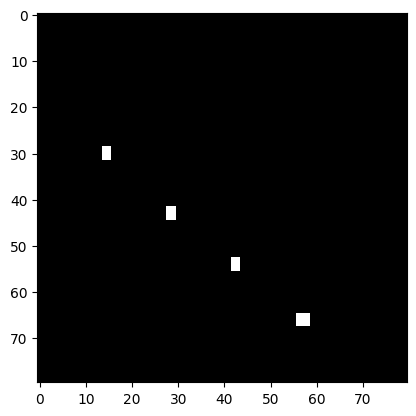

In [10]:
plt.imshow(t[2][0][0], cmap='gray')

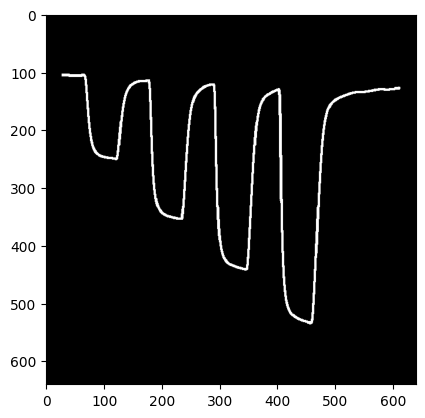

In [9]:
img = np.array(im.reshape(640, 640))
x, y, w, h = np.array(t['box'][0]*640, dtype=np.uint8)
img[img > 0] = 1


#p1 = (x - w // 2, y - h // 2)
#p2 = (x + w // 2, y + h // 2)
#cv2.rectangle(img, p1, p2, color=120, thickness=2)

plt.imshow(img, cmap='gray')
#plt.axis('off')
plt.show()

In [8]:
zeros = np.zeros((640, 640))
for b, l in zip(t['box'], t['cls']):
    x, y, w, h = np.array(b*640, dtype=np.int32)
    if l == 0:
        zeros[y - h // 2:y + h // 2, x - w // 2:x + w // 2] = 1

step = 640 // 20

tar = np.zeros((20, 20))

for i in range(0, 640, step):
    for j in range(0, 640, step):
        if np.sum(zeros[i:i+step, j:j+step]) > 0:
            zeros[i:i+step, j:j+step] = 1
            tar[i // step, j // step] = 1

zeros[:, ::step] = 1
zeros[::step, :] = 1


plt.imshow(zeros, cmap='gray')

TypeError: list indices must be integers or slices, not str